In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import pdb

from matplotlib import rc
rc('text', usetex=True)
import matplotlib.pyplot as plt
# %config InlineBackend.figure_format = 'svg'
from pprint import pprint

import polyphase as phase
from itertools import combinations
from numpy.linalg import norm

In [14]:
dimensions = 3

config_list = [{'M':np.array([64,1,1]), 'chi': [1.0,0.3,0.2] },
               {'M':np.array([5,5,1]), 'chi': [1.0,0.5,0.5]}, 
              {'M':np.array([20,20,1]), 'chi': [1.0,0.5,0.5]}, 
               {'M':np.array([946,12,1]), 'chi': [0.43,0.45,0.60]}, # penn state example
               {'M':np.array([20,7,1]), 'chi': [1.0,0.4,0.9]}, # Balaji Phafic bug
               {'M':np.array([1,1,1]), 'chi': [2.31,2.31,2.31]} # Softmatter paper
              ]
   
configuration = config_list[0]
dop_str = 'M:' + ','.join('{}'.format(m) for m in configuration['M'])
chi_str = r'$\chi$: ' + ','.join('{:.2f}'.format(c) for c in configuration['chi'])
config_str = dop_str+'\n'+chi_str

dx = 40
pprint(config_str)
kwargs = {'flag_lift_label': True, 'use_weighted_delaunay': False,\
          'flag_remove_collinear' : False, 'beta':1e-4, \
          'flag_make_energy_paraboloid': True, 'flag_lift_purecomp_energy': False, \
         'thresh':1}
pprint(kwargs)

out = phase.compute(3, configuration, dx,  **kwargs)
grid = out['grid']
num_comps = out['num_comps']
simplices = out['simplices']
output = out['output']

2020-08-13 18:16:38,416	INFO resource_spec.py:212 -- Starting Ray with 32.67 GiB memory available for workers and up to 16.35 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


'M:64,1,1\n$\\chi$: 1.00,0.30,0.20'
{'beta': 0.0001,
 'flag_lift_label': True,
 'flag_lift_purecomp_energy': False,
 'flag_make_energy_paraboloid': True,
 'flag_remove_collinear': False,
 'thresh': 1,
 'use_weighted_delaunay': False}


2020-08-13 18:16:38,945	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-08-13 18:16:39,760	INFO services.py:1165 -- View the Ray dashboard at localhost:8265


3-dimensional grid generated at 0.00s
Energy computed at 0.02s
Making energy manifold a paraboloid with 2x padding of -0.00 maximum energy
Energy is corrected at 1.74s
Convexhull is computed at 1.75s
Using 6.78E-02 as a threshold for Laplacian of a simplex
Total of 855 simplices in the convex hull
Simplices are labelled at 2.67s
Labels are lifted at 3.26s
Total 0/855 coplanar simplices
Computation took 3.28s


In [ ]:
""" Post-processing """
%matplotlib inline
plt.close('all')
ax, cbar = phase.plot_mpltern(grid, simplices, num_comps)
ax.set_title(config_str, pad=20)
plt.show()

## Use different ways to classifiy simplices
Our goal in this task is to identify a more robust method to classify simplices. Our baseline method is the default connected components based phase identification. Other approaches we can use are:
1. Compute a clustering based on distance between triangles
2. Use classification mentioned in [CEM Paper](https://doi.org/10.1016/j.fluid.2012.04.002) -- works for realizing whether a a triangle represents a stable or phase seperation
3. Hand designed classifier -- A simplex is single phase if it is rehular with small edge lengths (~minimum size of delaunay edges) others are based on number of connected components.

In [39]:
from scipy.spatial import Delaunay
delaunay = Delaunay(np.asarray(grid[:-1,:].T))
max_delaunay_edge = 0.0
for sx in delaunay.simplices:
    vertex_sx = [grid[:,x] for x in sx]
    edges = combinations(vertex_sx, 2)
    edge_lengths = np.array([norm(e[0]-e[1]) for e in edges])
    current_max = np.max(edge_lengths)
    if max_delaunay_edge<current_max:
        max_delaunay_edge = current_max
        
print('Maximum Delaunay edge length : {}'.format(max_delaunay_edge))

Maximum Delaunay edge length : 0.02474232038675042


In [40]:
def get_cem_label(vertices):
    """
    Given a set of vertices of shape (3,3) returns 1 if a triangle formed by them
    is a small regular (equilateral or isosceles) triangle; 2 if the triangle is a large irregular scalane or oblique 
    """
    edges = combinations(vertices, 2)
    edge_lengths = np.array([norm(e[0]-e[1]) for e in edges])
    bool_streched_edges = np.array([el>=max_delaunay_edge for el in edge_lengths])
    if not bool_streched_edges.any():
        phase = 1
    else:
        phase = 2

    return phase
    

In [41]:
from scipy.spatial.distance import pdist, squareform

def get_hand_designed_label(vertices):
    epsilon = 5e-3
    edges = combinations(vertices, 2)
    edge_lengths = np.array([norm(e[0]-e[1]) for e in edges])
    bool_streched_edges = np.array([el>=max_delaunay_edge +epsilon for el in edge_lengths])
    
    if not bool_streched_edges.any():
        phase = 1
    else:
        phase = np.sum(bool_streched_edges)
    
    return phase
        

In [72]:
from scipy.spatial.distance import euclidean

def get_uniformedge_label(vertices):
    thresh = 5*euclidean(grid[:,0],grid[:,1])
    dist = squareform(pdist(vertices,'euclidean'))
    adjacency = dist<thresh
    adjacency =  adjacency.astype(int)  
    graph = csr_matrix(adjacency)
    n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)

    return n_components

In [123]:
import cechmate as cm
from persim import plot_diagrams
rips = cm.Rips(maxdim=1, verbose=False) #Go up to 1D homology

def get_peristence_label(vertices):
    rips.build(np.asarray(vertices))
    dgmsrips = rips.diagrams()
    H0 = dgmsrips[0]
    deaths = np.hstack((0.0,np.sort(H0[:,1]), 1.05))
    lifetimes = np.diff(deaths)
    label = np.argmax(np.flip(lifetimes))+1
    return label


In [124]:
test_triangle = 3793
test_vertices = [grid[:,x] for x in simplices[test_triangle]]
print(test_vertices)
print('Laplace label:{}'.format(num_comps[test_triangle]))
cem_label = get_cem_label(test_vertices)
print('CEM label: {}'.format(cem_label))
hd_label = get_hand_designed_label(test_vertices)
print('Hand designed label: {}'.format(hd_label))
pl_label = get_peristence_label(test_vertices)
print('Persistence lifetime label: {}'.format(pl_label))

[array([0.0909091 , 0.42424243, 0.48484849]), array([0.14141415, 0.3939394 , 0.46464647]), array([0.06060607, 0.44444445, 0.4949495 ])]
Laplace label:3
CEM label: 2
Hand designed label: 3
Persistence lifetime label: 1


In [ ]:
methods =[get_cem_label, get_hand_designed_label, get_peristence_label]
methods_names = ['CEM', 'Hand designed', 'Persistence lifetime']
fig, axs = plt.subplots(1,len(methods), figsize=(len(methods)*4*1.6, 4), subplot_kw={'projection':'ternary'})
axs = axs.flatten()
for i, method in enumerate(methods):
    labels = []
    for sx in simplices:
        vertex_sx = [grid[:,x] for x in sx]
        labels.append(method(vertex_sx))
    plot_mpltern(grid, simplices, labels, ax = axs[i])
    axs[i].set_title(methods_names[i], pad=25)
plt.show()

In [44]:
for i, sx in enumerate(simplices):
    vertex_sx = [grid[:,x] for x in sx]
    laplace_label = num_comps[i]
    cem_label = get_cem_label(vertex_sx)
    hd_label = get_hand_designed_label(vertex_sx)
    if not cem_label==laplace_label:
        print('CEM did not agree for {}'.format(i))
    if not hd_label==laplace_label:
        print('Hand designed did not agree for {}'.format(i))
    break

In [118]:
np.where(np.asarray(num_comps)==3)

(array([  29, 1002, 1860, 2540, 3750, 3793, 4999, 5421]),)

In [ ]:
from solvers.test_utils import *
test_triangle = 3793
test_vertices = [grid[:,x] for x in simplices[test_triangle]]
plot_simplicial_topolgy(np.asarray(test_vertices))
fig = plt.gcf()
fig.suptitle('Label : {} with threshold: {:2.3f}'.format(num_comps[test_triangle], max_delaunay_edge))
plt.show()

In [13]:
# import mpltern
# def plot_ternary_wireframe(grid, simplices, ax):
#     for s in simplices:
#         simplex_points = np.asarray([grid[:,x] for x in s])
#         ax.fill(simplex_points[:,2], simplex_points[:,0], simplex_points[:,1], facecolor='none', edgecolor='gray')
        
# fig, axs = plt.subplots(1,2, figsize=(7*2*1.6,7), subplot_kw={'projection':'ternary'})
# plot_ternary_wireframe(grid, delaunay.simplices, axs[0])
# axs[0].set_title('Delaunay triangulation of initial grid', pad=25)
# plot_ternary_wireframe(grid, simplices, axs[1])
# axs[1].set_title('Projected convex hull', pad=25)
# plt.show()

## Clustering simplices

Use a feature vector based on edge lengths to compute a network of simplices. The goal is to split the network into multiple phases via spectral clustering.

In [23]:
from scipy.spatial.distance import pdist, squareform

def get_edge_feature_vector(vertices, max_delaunay_edge):
    edges = combinations(vertices, 2)
    edge_lengths = np.array([norm(e[0]-e[1]) for e in edges])
    
    theta = edge_lengths/max_delaunay_edge
    
    return theta

def get_features_from_simplices(grid, simplices, max_delaunay_edge):
    theta_set = []
    for sx in simplices:
        sx_vertices = []
        for x in sx:
            sx_vertices.append(grid[:,x])
        theta_sx = get_edge_feature_vector(sx_vertices, max_delaunay_edge)
        theta_set.append(theta_sx)
    theta_set = np.asarray(theta_set)
    assert np.shape(theta_set)[1]==3, "Number of edges are greater than nCdim"
    assert np.shape(theta_set)[0]==np.shape(simplices)[0], "Number of features are greater than simplices"
    
    return theta_set

def get_area_and_angles(grid, simplices):
    theta_set = []
    for sx in simplices:
        sx_vertices = []
        for x in sx:
            sx_vertices.append(grid[:,x])
            
        A, B, C = sx_vertices
        ba = A-B
        bc = C-B
        alpha = np.degrees(np.arccos(np.dot(ba,bc)/(norm(ba)*norm(bc)+1e-4)))
        ca = A-C
        cb = B-C
        beta = np.degrees(np.arccos(np.dot(ca,cb)/(norm(ca)*norm(cb)+1e-4)))   

        gamma = 180-alpha-beta
    
        angles = np.round([alpha, beta, gamma])
        M= np.hstack((np.asarray(sx_vertices)[:,:-1],np.array([[1],[1],[1]])))
        area = np.abs(np.linalg.det(M)) 
        theta = np.hstack((area, angles))
        theta_set.append(theta)
        
    return np.asarray(theta_set)
                
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

#X = get_features_from_simplices(grid, simplices, max_delaunay_edge)
X = get_area_and_angles(grid, simplices)

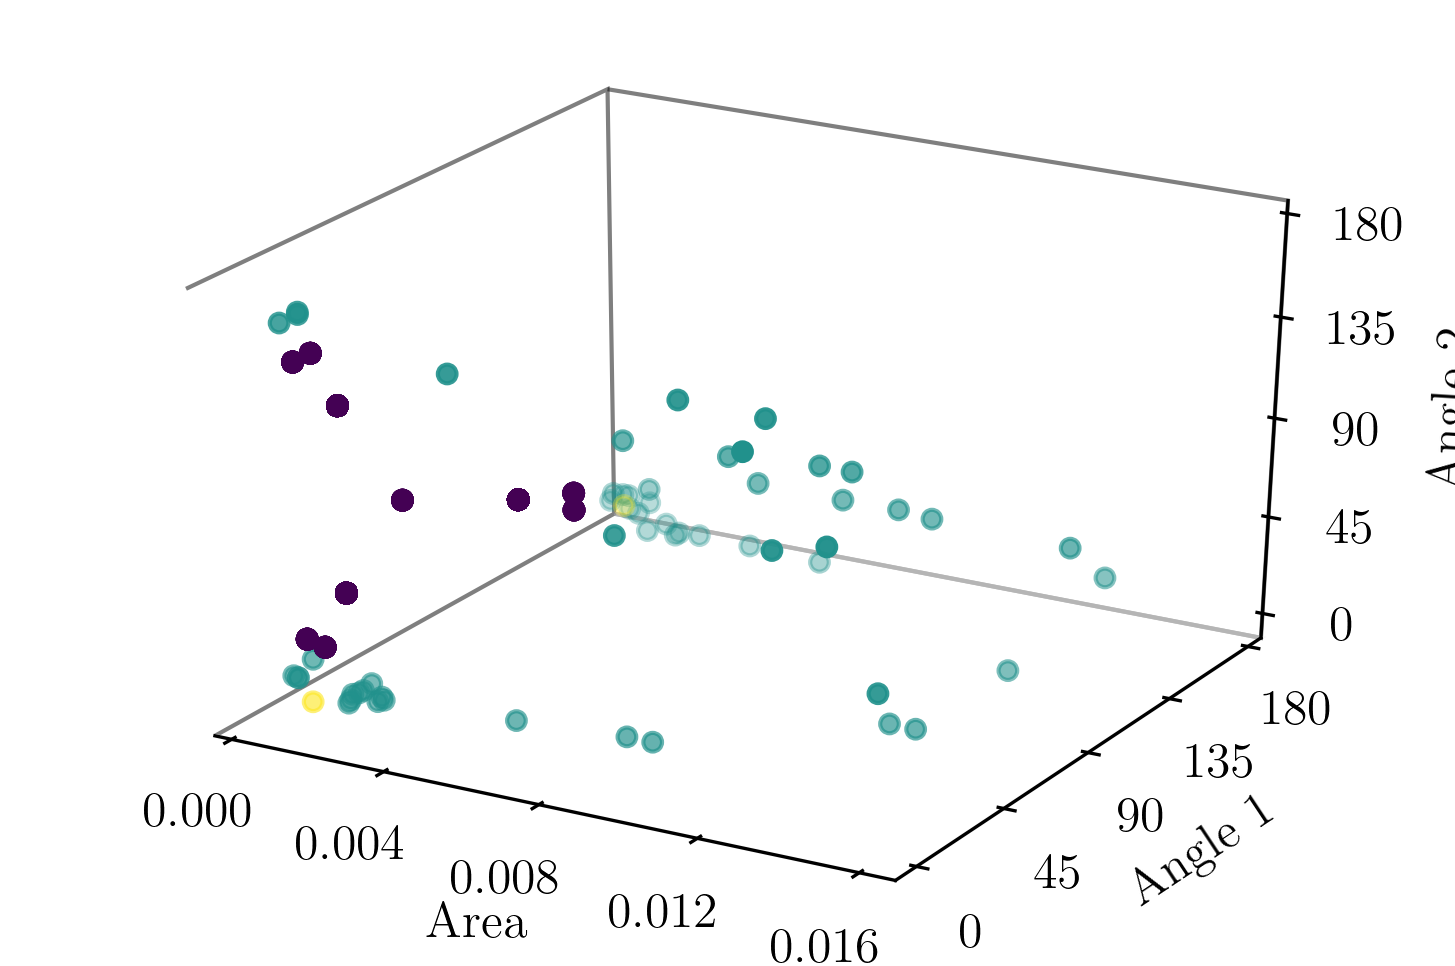

In [44]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MultipleLocator
from matplotlib import rc
rc('font',size=12)
rc('font',family='serif')
rc('axes',labelsize=12)

fig = plt.figure(dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c = num_comps)
ax.grid(False)
ax.set_xlabel('Area')
ax.set_ylabel('Angle 1')
ax.set_zlabel('Angle 2')
ax.xaxis.set_major_locator(MultipleLocator(0.004))
ax.yaxis.set_major_locator(MultipleLocator(45))
ax.zaxis.set_major_locator(MultipleLocator(45))
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

plt.show()

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=num_comps, cmap=discrete_cmap(4, 'jet'))
plt.colorbar(ticks=[1,2,3])
plt.show()

In [ ]:
# from sklearn.cluster import SpectralClustering

# clustering = SpectralClustering(n_clusters=2,
#         assign_labels="discretize",
#         random_state=0, affinity='precomputed').fit(D_norm)

# ax, cbar = plot_mpltern(grid, simplices, clustering.labels_+1)


In [ ]:
# Using Homology classes
# We use bottleneck distance between two peritence diagrams as a distance measure to cluster them
import persim
from persim.visuals import bottleneck_matching
import cechmate as cm
rips = cm.Rips(maxdim=1, verbose=False) #Go up to 1D homology
from persim import plot_diagrams


In [ ]:
from scipy.spatial.distance import pdist, squareform, euclidean
import ray
ray.init(ignore_reinit_error=True)
import time

@ray.remote
def get_distance_row(data, metric, rowid, triuids):
    rowid_flags = triuids[0]
    rows = triuids[0][rowid_flags==rowid]
    cols = triuids[1][rowid_flags==rowid]
    dist_row = []
    for r,c in zip(rows, cols):
        dist_row.append(metric(data[r,:], data[c,:]))
                        
    return dist_row


def dist_bottleneck(query, candidate, grid):
    
    v0 = [grid[:,x] for x in query]
    rips.build(np.asarray(v0))
    dgm0 = rips.diagrams()[0]

    v1 = [grid[:,int(x)] for x in candidate]
    rips.build(np.asarray(v1))
    dgm1 = rips.diagrams()[0]

    distance_bottleneck = persim.bottleneck(dgm0, dgm1, matching=False)
    
    return distance_bottleneck


def test_ray_distance():
    start = time.time()

    n_samples = 1000
    print('nC2 : {}'.format(0.5*(n_samples*(n_samples-1))))
    data_ray = ray.put(np.random.rand(n_samples, 3))
    iu = np.triu_indices(n_samples,1)
    print(iu[0].shape)
    iu_ray = ray.put(iu)
    row_ids = np.unique(iu[0])
    dfun = lambda u, v : dist_bottleneck(u,v)
    dist_ray = [get_distance_row.remote(data_ray, dfun, rowid, iu_ray) for rowid in row_ids]
    dist = np.hstack(ray.get(dist_ray))
    print(dist.shape)
    D = squareform(dist)
    print(D.shape)
    end = time.time()
    print('Elaspsed time is : {:.2f}'.format(end - start))
    
    del dist_ray, iu_ray, data_ray 

In [ ]:
start = time.time()

n_samples = len(simplices)
print('nC2 : {}'.format(0.5*(n_samples*(n_samples-1))))
data_ray = ray.put(np.asarray(simplices))
iu = np.triu_indices(n_samples,1)
print(iu[0].shape)
iu_ray = ray.put(iu)
row_ids = np.unique(iu[0])
dfun = lambda u, v : dist_bottleneck(u,v, grid)
dist_ray = [get_distance_row.remote(data_ray, dfun, rowid, iu_ray) for rowid in row_ids]
dist = np.hstack(ray.get(dist_ray))
print(dist.shape)
D = squareform(dist)
print(D.shape)
end = time.time()
print('Elaspsed time is : {:.2f}'.format(end - start))

del dist_ray, iu_ray, data_ray 

In [ ]:
from sklearn.manifold import TSNE

D_norm = D/D.max()
X_embedded = TSNE(n_components=2).fit_transform(D_norm)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=num_comps, cmap=discrete_cmap(4, 'jet'))
plt.colorbar(ticks=[1,2,3])
plt.show()